[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1vTbbnTw0o4nD8DLr0NB_5jDmTQ4s31lf?usp=sharing)

# **Week 4 - Introduction to Probabilistic Regression**

## **Abstract**

1.  **Introduction to Probabilistic Regression**: Probablistic Regression estimates the uncertainty of predicitions made by the model. This is done by integrating prior beliefs about the model parameters into the model.  

2. **Introduction to Bayes' Theorem to Regression**: Bayes' Theorem to Regression is a method of linear regression using probability distributions rather than point estimates. Using the Posterior Probability and evidence, the model can make predicitions.

3. **Introduction to Gaussian Processes in Regression**: The Gaussian Process is a subset of the Bayes' Theorem and uses predictions that are made by averaging over all possible functions according to their posterior probabilities.

4. **Introduction to Potential Energy Surface (PES)**: Potential Energy Surface Diagrams show the relationship between the energy and a molecule geometry. They are the cornerstone for many Cheminformatic functions.



>## **References: Essential Resources for Further Learning**
>
>1. **A Probabilistic View of Linear Regression**: [Educational Resource](https://luigicapogrosso.medium.com/a-probabilistic-view-of-linear-regression-47acd6f87b8d)
2. **Introduction to Bayesian Linear Regression**: [Educational Resource](https://towardsdatascience.com/introduction-to-bayesian-linear-regression-e66e60791ea7)
3. **A Visual Exploration of Gaussian Processes**: [Educational Resource](https://distill.pub/2019/visual-exploration-gaussian-processes/)
4. **Potential Energy Surfaces**: [Educational Resource](https://chem.libretexts.org/Courses/University_of_California_Davis/UCD_Chem_107B%3A_Physical_Chemistry_for_Life_Scientists/Chapters/2%3A_Chemical_Kinetics/2.06%3A_Potential_Energy_Surfaces)



Feel free to explore these resources to deepen your understanding of data visualization, data management, and computational tools in Chemistry.





In [1]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, Image
import os

## **Introduction to Probabilistic Regression**

Probabilistic regression is a statistical approach that extends beyond traditional regression by estimating the uncertainty of predictions. This method distinguishes itself by not only predicting a single outcome but also quantifying the uncertainty of the prediction.

<br>


### **Bayes' Theorem in Regression**

- **Bayes' Theorem Formula**:
  - The theorem is expressed as
  $$
  P(H | E) = \frac{P(E | H) \times P(H)}{P(E)}
  $$
  - Where:
    - $P(H | E)$ is the **posterior probability** of the hypothesis $H$ given the evidence $E$.
    - $P(E | H)$ is the **likelihood**, which measures how likely the evidence $E$ is, given the hypothesis $H$.
    - $P(H)$ is the **prior probability**, representing our belief about the hypothesis before seeing the evidence.
    - $P(E)$ is the **evidence** or **marginal likelihood**, serving as a normalizing constant to ensure the posterior is a valid probability distribution.

<br>

![Simple Explanation of Bayes’ Theorem](https://miro.medium.com/v2/resize:fit:3436/1*CmJJV6e0EuEhFdNafbX2Vg.gif) <br>
[**Figure 1 - Simple Explanation of Bayes’ Theorem. Image by Khuyen Tran**](https://towardsdatascience.com/bayes-theorem-clearly-explained-with-visualization-5083ea5e9b14)

<br>

### **Applying Bayes' Theorem to Regression**

In the context of Bayesian regression, this formula is applied as follows:

- **Hypothesis (H):** This corresponds to a particular set of parameters (or model) $\theta$.
- **Evidence (E):** This is the observed data.
- **Posterior Probability $P(H | E)$:** This is the probability of the model parameters $\theta$ given the observed data, $P(\theta | \text{Data})$.
- **Likelihood $P(E | H)$:** This is the probability of observing the data given the model parameters, $P(\text{Data} | \theta)$.
- **Prior Probability $P(H)$:** This is the prior belief about the model parameters, $P(\theta)$.
- **Evidence $P(E)$:** This is the probability of observing the data under all possible models, often viewed as a normalizing factor.

In Bayesian regression, we compute the posterior distribution $P(\theta | \text{Data})$ using this framework, which then forms the basis for making predictions and inferences.

<br>

![Bayesian Linear Regression Visualization](https://cdn.dida.do/blog/20200217_MW_what-is-blr/blr.gif) <br>
[**Figure 2 - Bayesian Linear Regression Visualization. Image by Matthias Werner**](https://dida.do/blog/what-is-bayesian-linear-regression)

<br>



### **Generating Random Parameters**


$$f(x) = \sin(x) + x -1 + {U}_i;$$
$${U}_i \sim {U}([0,0.5])$$

In [2]:
# generate random data over f(x) = sin(x) + x - 1
def get_data(N,bool_biased=False):
    # x = np.linspace(-1.,1.,N)
    x = np.random.uniform(low = -1.,high=1.,size=N)
    y = np.sin(.5*x) + x -1.
    y = y + np.random.uniform(low = 0.,high=1.5,size=x.shape)
    # X_w_ones = np.column_stack((x,np.ones_like(x)))
    if bool_biased:
        X = np.column_stack((x,np.ones_like(x)))
    else:
        X = x[:, None]
    return X,y

**Prior distribution**: distribution over the linear parameters
$$
p(\mathbf{w}) = {\cal N}(\mathbf{w}| \mathbf{m}_0, \lambda \mathbb{I})
$$
**Likelihood**: 
$$
p(\mathbf{y}_{p} |\mathbf{X},\mathbf{w},\sigma_n^{-1} ) = {\cal N}(\mathbf{y}_{p}| f(\mathbf{X},\mathbf{w}), \lambda^{-1}) = {\cal N}(y_{p}| \Phi(\mathbf{X})\mathbf{w}, \sigma_n^{-1}) 
$$
**Posterior distribution**: distribution over the linear parameters condition on the training data

$$
p(\mathbf{w} |\mathbf{X},\mathbf{w},\lambda ) = {\cal N}(\mathbf{w}| \Sigma \mathbf{X}^\top\mathbf{y}, \Sigma),
$$
$$
\Sigma = (\mathbf{X}^\top\mathbf{X} + \lambda \mathbb{I})^{-1}
$$

Check [Bishop's book](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) Equation 2.116

In [3]:
def calculate_posterior_params(data, l=0.001):
    Xtr, ytr = data  # training data
    l_I = l * np.eye(Xtr.shape[1], Xtr.shape[1])
    A = l_I + Xtr.T @ Xtr
    A_inv = np.linalg.inv(A)

    mean = A_inv @ (Xtr.T @ ytr)
    sigma = A_inv
    return mean, sigma

In [4]:
# generate data
n_points = 10
data = get_data(n_points, True)

[ 1.25801985 -0.23595798]


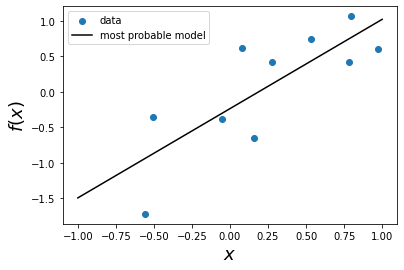

In [5]:
x_grid = np.linspace(-1., 1., 100)
X_grid = np.column_stack((x_grid,np.ones_like(x_grid)))


# plt.figure(figsize=(8,6))
plt.scatter(data[0][:,0],data[1],label='data')

mean,_ = calculate_posterior_params(data)
print(mean)
y_pred = X_grid @ mean # Represents the data likelihood
plt.plot(x_grid,y_pred,c='k',label='most probable model')

plt.legend()
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$f(x)$', fontsize=18)
plt.show()


Text(0, 0.5, '$f(x)$')

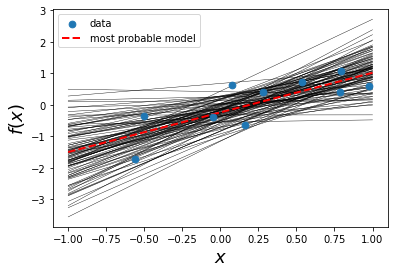

In [6]:
mean,std = calculate_posterior_params(data)
random_theta = np.random.multivariate_normal(mean,std,100)

plt.figure(0)
plt.scatter(data[0][:,0],data[1],label='data',zorder=3.5,s=45)
plt.plot(x_grid, X_grid @ mean, c='r',
         label='most probable model', ls='--',lw=2., zorder=2.5)
for t  in random_theta:
    y_pred = X_grid @ t
    plt.plot(x_grid,y_pred,c='k',lw=0.4)

plt.legend()
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$f(x)$', fontsize=18)



*   **Blue Points:** These represent the actual observed data points.
  
*   **Black Lines:** Each of these represents a regression line sampled from the posterior distribution. They give a sense of the uncertainty in the regression model; where they are dense, there is more certainty about the model, and where they spread out, there is more uncertainty.

*   **Red Dashed Line:** This is the most probable regression line based on the mean of the posterior distribution.

Text(0, 0.5, '$\\theta_0$')

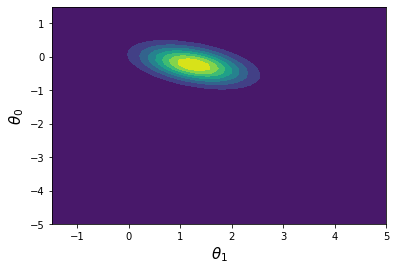

In [7]:
from scipy.stats import multivariate_normal
theta1, theta0 = np.meshgrid(
    np.linspace(-1.5, 5, 50), np.linspace(-5,1.5 , 50))
pos = np.empty(theta0.shape + (2,))
pos[:, :, 0] = theta1; pos[:, :, 1] = theta0

rv = multivariate_normal(mean=mean, cov=std)

plt.contourf(theta1, theta0, rv.pdf(pos))
plt.xlabel(R'$\theta_1$',fontsize=15)
plt.ylabel(R'$\theta_0$', fontsize=15)

The code and the resulting graph are a way to visualize a bivariate (two-variable) normal distribution which represents the possible values for two parameters, typically $\theta_0 $ and $\theta_1 $, in a Bayesian regression model. Let's break it down to understand better:

### **Understanding the Code**

1. **Multivariate Normal Distribution:**
   - The code defines a multivariate normal distribution using `mean` and `std`.

2. **Meshgrid:**
   - The meshgrid created by `np.meshgrid` is a grid of points where the distribution is evaluated. Think of it like laying a net over a region where you expect to find fish; where the fish are the values of $\theta_0 $ and $\theta_1 $.

3. **Probability Density Function (PDF):**
   - The `rv.pdf(pos)` computes the probability density at each point on the grid. The denser the points, the more likely the values at that point are the true parameter values.


The graph is used to create a visual representation of where the model believes the true parameter values are likely to be based on the data and prior information. The graph shows these beliefs in a way that can be easily understood.

In [14]:
from scipy.stats import multivariate_normal


def frame(data):
    x, y = data
    mean, std = calculate_posterior_params(data)
    random_theta = np.random.multivariate_normal(
        mean, std, 50)  # sample parameters

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # left panel
    x_grid = np.linspace(-1., 1., 100)
    X_grid = np.column_stack((x_grid, np.ones_like(x_grid)))
    axs[0].scatter(x[:, 0].ravel(), y, label='data', zorder=3.5, s=70)
    axs[0].plot(x_grid, X_grid @ mean, c='r',
                label=r'$\mathbf{\theta}_{MAP}^{*}$', ls='--', lw=2., zorder=2.5)
    for t in random_theta:
        y_pred = X_grid @ t
        axs[0].plot(x_grid, y_pred, c='k', lw=0.4)

    axs[0].legend(fontsize=15)
    axs[0].set_xlabel(r'$x$', fontsize=18)
    axs[0].set_ylabel(r'$f(x)$', fontsize=18)

    # right panel
    theta1, theta0 = np.meshgrid(
        np.linspace(-5., 5., 50), np.linspace(-5., 5., 100))
    pos = np.empty(theta0.shape + (2,))
    pos[:, :, 0] = theta1
    pos[:, :, 1] = theta0
    rv = multivariate_normal(mean=mean, cov=std)  # compute PDF

    axs[1].contourf(theta1, theta0, rv.pdf(pos))
    axs[1].set_xlabel(R'$\theta_1$', fontsize=15)
    axs[1].set_ylabel(R'$\theta_0$', fontsize=15)

    # plt.show()
    # plt.savefig('Figures/prob_lr_%s.png' % (y.shape[0]-1), dpi=900)

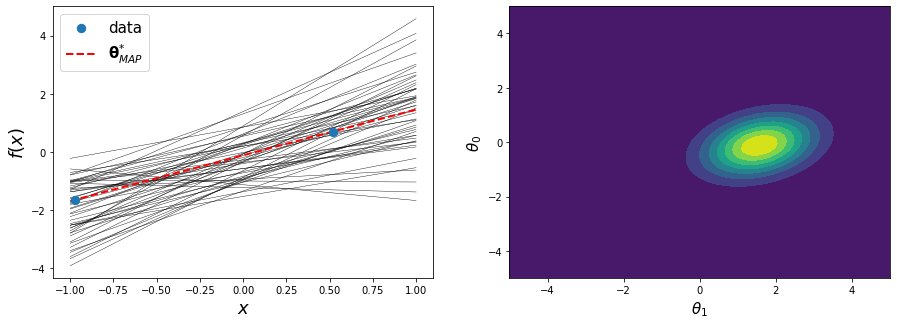

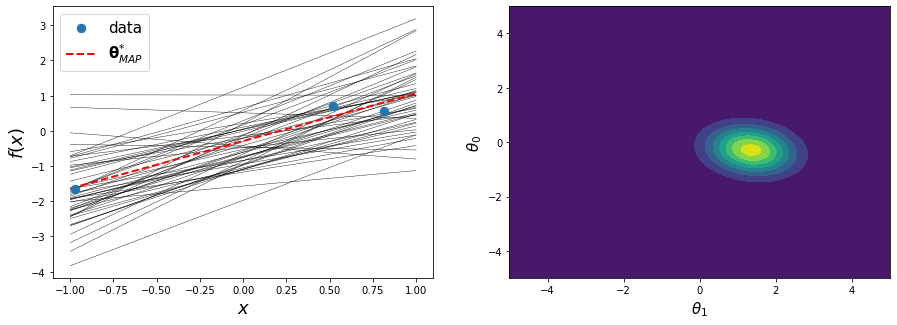

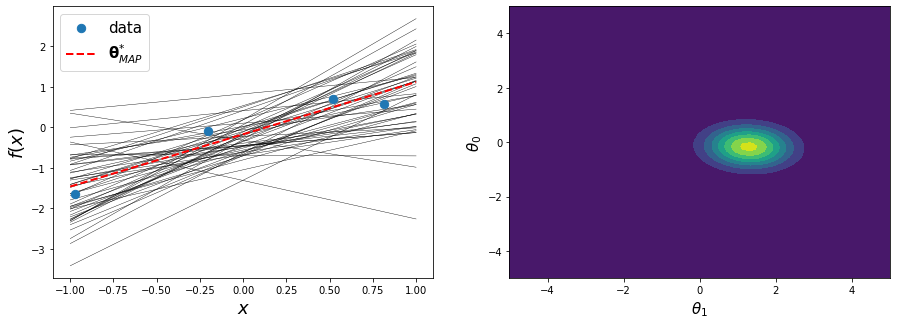

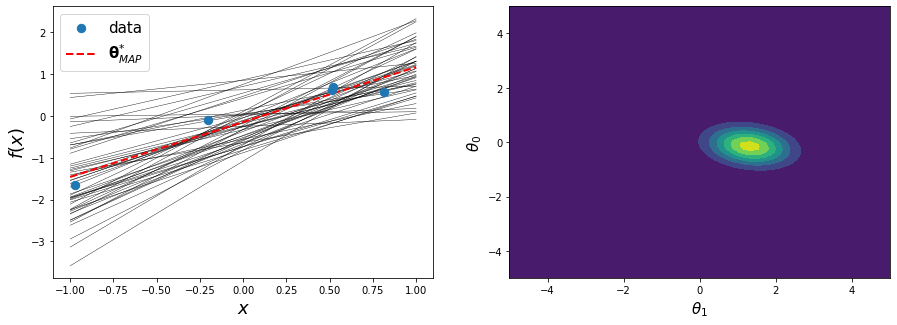

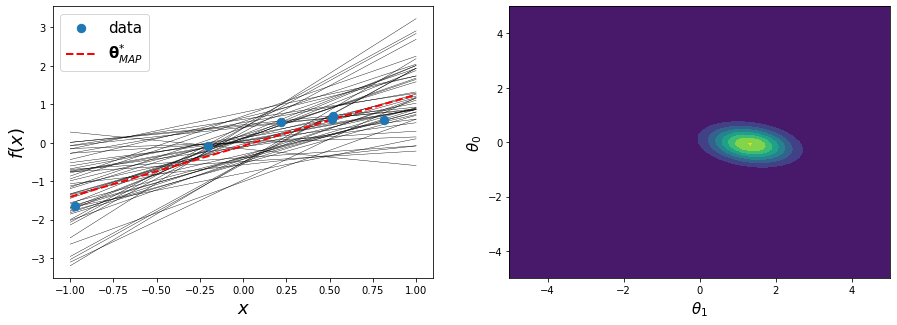

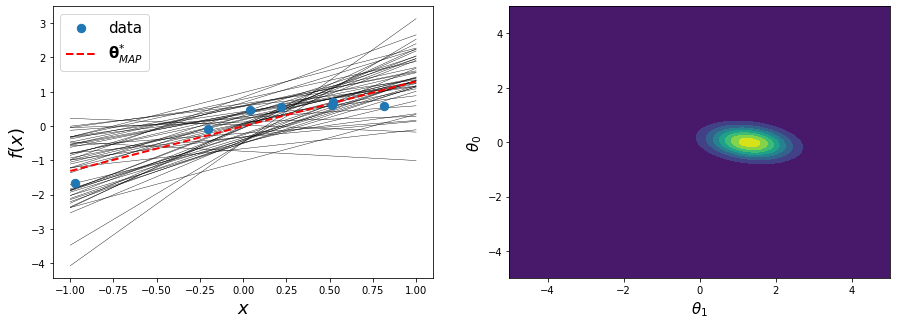

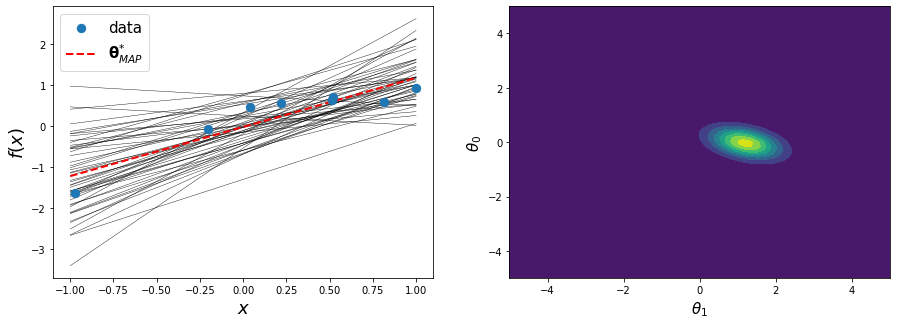

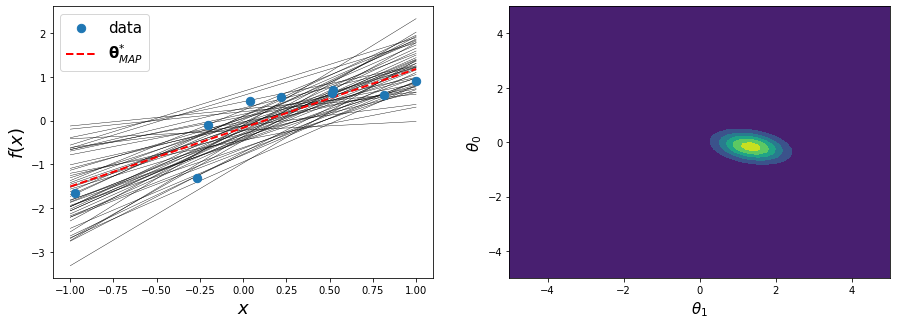

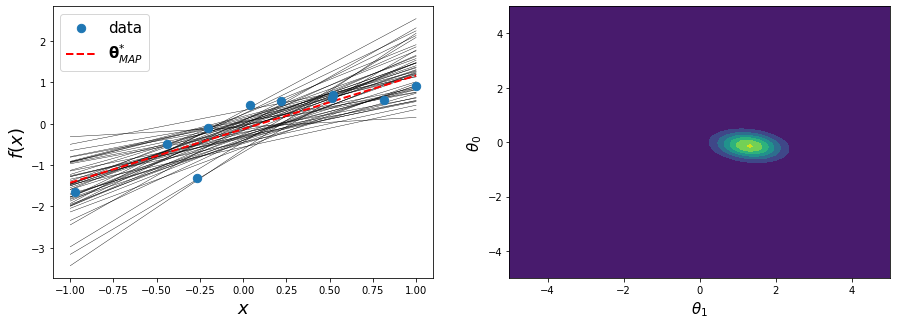

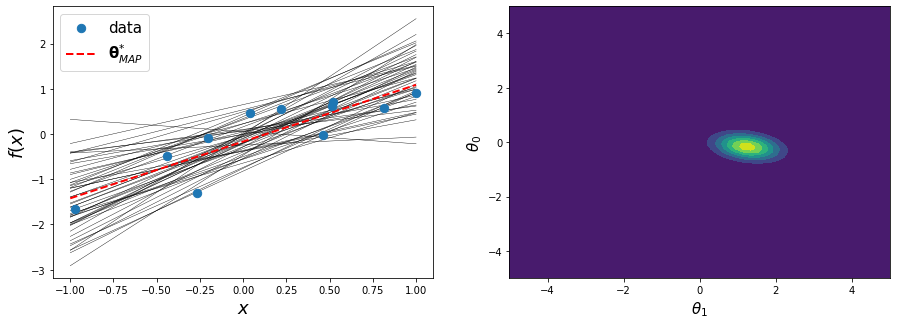

In [17]:
n_points = 1
data = get_data(n_points, True)

for i in range(10):
    data1 = get_data(1, True)
    x = np.vstack((data[0], data1[0]))
    y = np.append(data[1], data1[1])
    data = (x, y)
    frame(data)

## **Next Week - Gaussian Processes and Kernel methods**

